## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [324]:
import os
# Opening JSON file
with open('complaints.json', 'r') as file:
    data = json.load(file)
df=pd.json_normalize(data)

## Data preparation

In [327]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [329]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [331]:
#Assign new column names
df.columns = df.columns.str.replace("source.","")

In [333]:
df.columns = df.columns.str.lstrip("_")

In [335]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [337]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace('',np.nan)

In [339]:
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [341]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint_what_happened'])

In [343]:
df.isna().sum()

index                            0
type                             0
id                               0
score                            0
tags                         17256
zip_code                      4645
complaint_id                     0
issue                            0
date_received                    0
state                          143
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      21070
sub_product                   2109
timely                           0
complaint_what_happened          0
sub_issue                     8176
consumer_consent_provided        0
dtype: int64

In [345]:
df.size

463584

In [347]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [350]:
import re
import string
# Write your function here to clean the text and remove all the unnecessary elements.
def cleanText(text):
    text = text.lower()
    text =  re.sub("[.*?]","",text)
    text = ''.join(char for char in text if char not in string.punctuation)
    text =  re.sub(r'\b\w*\d\w*\b', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [352]:
print(cleanText("I am [abcd] (abcd) aor9 super, great"))

i am abcd abcd super great


In [354]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [356]:
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dganguly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [358]:
#Write your function to Lemmatize the texts
def lemmatize(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatized_tokens = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [360]:
print(lemmatize('The quick brown foxes are jumping over the lazy dogs.'))

The quick brown fox jump lazy dog .


In [362]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df['clean_complaints'] = df['complaint_what_happened'].apply(lambda x : cleanText(x))

In [364]:
df['clean_complaints'] = df['clean_complaints'].apply(lambda x : lemmatize(x))

In [366]:
df_clean = df[['clean_complaints','complaint_what_happened']]

In [368]:
df_clean

,clean_complaints,complaint_what_happened
1,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...
2,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...
11,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX..."
14,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...
...,...,...
78303,chase card customer well decade offer multiple...,After being a Chase Card customer for well ove...
78309,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,familiar xxxx pay understand great risk provid...,I am not familiar with XXXX pay and did not un...
78311,flawless credit yrs ive chase credit card chas...,I have had flawless credit for 30 yrs. I've ha...


In [370]:
df_clean.to_csv("ticket_classification1.csv",index=False) #checkpoint

In [372]:
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dganguly\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [374]:
#Write your function to extract the POS tags an remove tags other than NN

def remove_pos_tags(text):
  # write your code here
  tokenized_text = word_tokenize(text)  
  pos_tags = nltk.tag.pos_tag(tokenized_text)
  text = []  
  for word,pos_tag  in pos_tags:
     if pos_tag == "NN":
         text.append(word)
  joined_text = ' '.join(text)
  return joined_text



In [376]:
print(remove_pos_tags("NLTK is a powerful library for natural language processing."))

library language processing


In [378]:
df_clean["complaint_POS_removed"] = df_clean['clean_complaints'].apply(lambda x : remove_pos_tags(x))



C:\Users\dganguly\AppData\Local\Temp\ipykernel_34420\2032528542.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [388]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,clean_complaints,complaint_what_happened,complaint_POS_removed
0,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...,morning name appreciate chase bank cardmember ...
1,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card tell agent date information order upgrade...
2,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...,card report application submit identity consen...
3,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket come offer apply ticket card infor...
4,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...,son check deposit chase account fund bank acco...
...,...,...,...
21067,chase card customer well decade offer multiple...,After being a Chase Card customer for well ove...,chase card customer decade offer credit card c...
21068,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",call chas xxxx credit card provider claim purc...
21069,familiar xxxx pay understand great risk provid...,I am not familiar with XXXX pay and did not un...,pay risk chase bank bank tell deal merchant me...
21070,flawless credit yrs ive chase credit card chas...,I have had flawless credit for 30 yrs. I've ha...,flawless credit chase credit card chase freedo...


In [382]:
df_clean.to_csv("ticket_classification2.csv",index=False) #checkpoint2

In [384]:
df_clean = pd.read_csv("ticket_classification2.csv")

In [386]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].astype(str)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




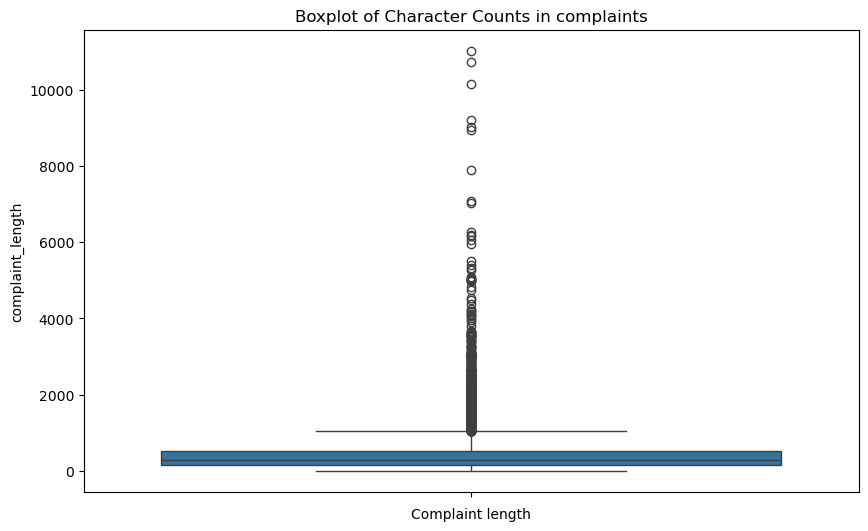

In [391]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_POS_removed'].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_clean['complaint_length'])
plt.title('Boxplot of Character Counts in complaints')
plt.xlabel('Complaint length')
plt.show()

In [393]:
df_clean['complaint_length'].describe()

count    21072.000000
mean       411.113278
std        454.763240
min          3.000000
25%        157.000000
50%        290.000000
75%        516.000000
max      11028.000000
Name: complaint_length, dtype: float64

50% Words within 290 characters lenth, maximum goingupto 11000 characters

#### Find the top 40 words by frequency among all the articles after processing the text.

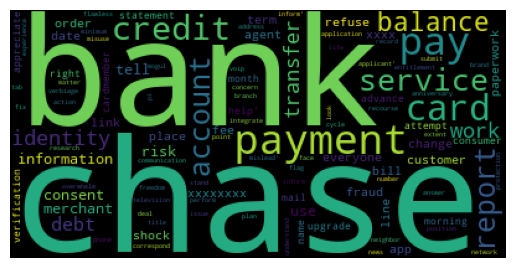

In [397]:
from wordcloud import WordCloud
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
text = df_clean['complaint_POS_removed'].values
wordcloud = WordCloud().generate(str(text))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [399]:
##top 40 words in complaints
list(wordcloud.words_.keys())[:40]

['chase',
 'bank',
 'payment',
 'pay',
 'card',
 'credit',
 'service',
 'account',
 'report',
 'balance',
 'identity',
 'work',
 'transfer',
 'debt',
 'information',
 'tell',
 'consent',
 'risk',
 'merchant',
 'use',
 'agent',
 'date',
 'order',
 'change',
 'xxxx',
 'refuse',
 'fraud',
 'place',
 'app',
 'customer',
 'link',
 'bill',
 'shock',
 'fee',
 'xxxxxxxx',
 'paperwork',
 'everyone',
 'term',
 'line',
 'morning']

In [401]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [404]:
text = " ".join(text)

In [406]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
unigram_freq = Counter(tokens)


In [407]:
#Print the top 10 words in the unigram frequency
unigram_freq.most_common(10)

[('chase', 51829),
 ('account', 42495),
 ('credit', 34175),
 ('bank', 30058),
 ('card', 26245),
 ('call', 17441),
 ('charge', 16835),
 ('time', 16119),
 ('payment', 13968),
 ('xxxx', 13232)]

In [410]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigrams = list(ngrams(tokens, 2))
bigram_freq = Counter(bigrams)

In [412]:
#Print the top 10 words in the bigram frequency
bigram_freq.most_common(10)

[(('credit', 'card'), 12612),
 (('chase', 'bank'), 5326),
 (('credit', 'report'), 5028),
 (('check', 'account'), 4060),
 (('customer', 'service'), 3067),
 (('call', 'chase'), 3014),
 (('chase', 'credit'), 2952),
 (('bank', 'account'), 2622),
 (('account', 'chase'), 2125),
 (('chase', 'account'), 1949)]

In [414]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigrams = list(ngrams(tokens, 3))
trigram_freq = Counter(trigrams)

In [416]:
#Print the top 10 words in the trigram frequency
trigram_freq.most_common(30)

[(('chase', 'credit', 'card'), 2088),
 (('credit', 'card', 'company'), 996),
 (('credit', 'card', 'account'), 897),
 (('credit', 'card', 'chase'), 697),
 (('credit', 'card', 'credit'), 536),
 (('chase', 'customer', 'service'), 484),
 (('credit', 'report', 'credit'), 467),
 (('charge', 'credit', 'card'), 458),
 (('report', 'credit', 'report'), 445),
 (('chase', 'check', 'account'), 419),
 (('call', 'customer', 'service'), 373),
 (('account', 'credit', 'card'), 368),
 (('bank', 'credit', 'card'), 356),
 (('credit', 'card', 'bank'), 353),
 (('card', 'credit', 'card'), 346),
 (('chase', 'bank', 'account'), 335),
 (('credit', 'report', 'act'), 335),
 (('check', 'account', 'bank'), 328),
 (('credit', 'card', 'charge'), 326),
 (('check', 'account', 'chase'), 302),
 (('call', 'chase', 'bank'), 301),
 (('account', 'credit', 'report'), 293),
 (('chase', 'fraud', 'department'), 275),
 (('pay', 'credit', 'card'), 271),
 (('use', 'credit', 'card'), 264),
 (('phone', 'call', 'chase'), 259),
 (('cons

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [419]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [465]:
#All masked texts has been removed
df_clean

,clean_complaints,complaint_what_happened,complaint_POS_removed,complaint_length,Complaint_clean
0,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...
1,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card tell agent date information order upgrade...,112,card tell agent date information order upgrade...
2,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...,card report application submit identity consen...,81,card report application submit identity consen...
3,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket come offer apply ticket card infor...,425,book ticket come offer apply ticket card infor...
4,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...
...,...,...,...,...,...
21067,chase card customer well decade offer multiple...,After being a Chase Card customer for well ove...,chase card customer decade offer credit card c...,193,chase card customer decade offer credit card c...
21068,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",call chas xxxx credit card provider claim purc...,675,call chas credit card provider claim purchase...
21069,familiar xxxx pay understand great risk provid...,I am not familiar with XXXX pay and did not un...,pay risk chase bank bank tell deal merchant me...,607,pay risk chase bank bank tell deal merchant me...
21070,flawless credit yrs ive chase credit card chas...,I have had flawless credit for 30 yrs. I've ha...,flawless credit chase credit card chase freedo...,549,flawless credit chase credit card chase freedo...


In [425]:
df_clean.to_csv("ticket_classification3.csv",index=False) #checkpoint 3

In [116]:
df_clean = pd.read_csv("ticket_classification3.csv")

In [118]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].astype(str)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [121]:
#Write your code here to initialise the TfidfVectorizer
vect = TfidfVectorizer(stop_words='english', max_df = 0.95, min_df = 2)




#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [124]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = vect.fit_transform(df_clean['Complaint_clean'])

In [126]:
dtm.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [128]:
pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names_out())

,aarp,aback,abandon,abandonment,abatement,abbreviation,abd,abet,abhorrent,abide,...,youve,yr,yrs,ys,ytd,zero,zip,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [131]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [134]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [136]:
nmf_model.fit(dtm)
len(vect.get_feature_names_out())

6751

In [138]:
#Print the Top15 words for each of the topics
H = nmf_model.components_  
words = np.array(vect.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,bank,check,money,chase,deposit,fund,branch,tell,number,transfer,claim,business,fraud,cash
Topic 1,credit,report,card,chase,inquiry,account,company,score,information,debt,limit,letter,application,use,bureaus
Topic 2,loan,mortgage,home,chase,modification,property,letter,time,house,refinance,rate,bank,document,foreclosure,sale
Topic 3,charge,card,chase,fee,dispute,purchase,merchant,fraud,claim,transaction,refund,service,time,company,pay
Topic 4,payment,balance,pay,fee,month,statement,auto,date,time,account,chase,day,transfer,car,post


In [140]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W = nmf_model.transform(dtm)
W = pd.DataFrame(W, columns=[i for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: x.idxmax(), axis=1)

In [141]:

W

,0,1,2,3,4,max_topic
0,0.025294,0.013643,0.020524,0.009472,0.008027,0
1,0.009896,0.013064,0.007070,0.009941,0.004534,1
2,0.000000,0.056798,0.001149,0.000000,0.000000,1
3,0.019769,0.063828,0.017471,0.008409,0.000000,1
4,0.075365,0.000000,0.000000,0.000000,0.002594,0
...,...,...,...,...,...,...
21067,0.000000,0.078356,0.000000,0.067076,0.022475,1
21068,0.008516,0.012218,0.014480,0.033317,0.000000,3
21069,0.028982,0.015958,0.010924,0.020447,0.000000,0
21070,0.000000,0.040275,0.002758,0.018858,0.120015,4


In [144]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic']

In [146]:
df_clean

,clean_complaints,complaint_what_happened,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
1,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card tell agent date information order upgrade...,112,card tell agent date information order upgrade...,1
2,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket come offer apply ticket card infor...,425,book ticket come offer apply ticket card infor...,1
4,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,0
...,...,...,...,...,...,...
21067,chase card customer well decade offer multiple...,After being a Chase Card customer for well ove...,chase card customer decade offer credit card c...,193,chase card customer decade offer credit card c...,1
21068,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",call chas xxxx credit card provider claim purc...,675,call chas credit card provider claim purchase...,3
21069,familiar xxxx pay understand great risk provid...,I am not familiar with XXXX pay and did not un...,pay risk chase bank bank tell deal merchant me...,607,pay risk chase bank bank tell deal merchant me...,0
21070,flawless credit yrs ive chase credit card chas...,I have had flawless credit for 30 yrs. I've ha...,flawless credit chase credit card chase freedo...,549,flawless credit chase credit card chase freedo...,4


In [152]:
#Print the first 5 Complaint for each of the Topics
df_clean_5=df_clean.groupby('Topic').head(5)
df_clean_5=df_clean_5.sort_values('Topic')
df_clean_5

,clean_complaints,complaint_what_happened,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,0
4,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,0
6,notice jp morgan chase restrict account debit ...,With out notice J.P. Morgan Chase restricted m...,jp restrict account debit card tuesday thursda...,555,jp restrict account debit card tuesday thursda...,0
10,mishandle account chase auto xxxx,mishandling of this account by Chase auto and ...,account auto xxxx,17,account auto,0
12,open account chase bank xxxx use code xxxx bon...,I opened an account with chase bank on XXXX an...,account bank xxxx use code bonus call term tel...,124,account bank use code bonus call term tell ev...,0
1,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card tell agent date information order upgrade...,112,card tell agent date information order upgrade...,1
2,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...,card report application submit identity consen...,81,card report application submit identity consen...,1
3,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket come offer apply ticket card infor...,425,book ticket come offer apply ticket card infor...,1
5,please remove inquiry,Can you please remove inquiry,inquiry,7,inquiry,1
9,chase credit card incorrectly report data cred...,I have a Chase credit card which is incorrectl...,chase credit card credit report company issue,45,chase credit card credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [155]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0 : "Bank Account services", 1 : "Credit card or prepaid card", 2: "Mortgage/Loan", 3 : "Theft/Dispute Reporting", 4 : "Others" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [157]:
df_clean

,clean_complaints,complaint_what_happened,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,Bank Account services
1,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card tell agent date information order upgrade...,112,card tell agent date information order upgrade...,Credit card or prepaid card
2,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...,card report application submit identity consen...,81,card report application submit identity consen...,Credit card or prepaid card
3,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket come offer apply ticket card infor...,425,book ticket come offer apply ticket card infor...,Credit card or prepaid card
4,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,Bank Account services
...,...,...,...,...,...,...
21067,chase card customer well decade offer multiple...,After being a Chase Card customer for well ove...,chase card customer decade offer credit card c...,193,chase card customer decade offer credit card c...,Credit card or prepaid card
21068,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",call chas xxxx credit card provider claim purc...,675,call chas credit card provider claim purchase...,Theft/Dispute Reporting
21069,familiar xxxx pay understand great risk provid...,I am not familiar with XXXX pay and did not un...,pay risk chase bank bank tell deal merchant me...,607,pay risk chase bank bank tell deal merchant me...,Bank Account services
21070,flawless credit yrs ive chase credit card chas...,I have had flawless credit for 30 yrs. I've ha...,flawless credit chase credit card chase freedo...,549,flawless credit chase credit card chase freedo...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [159]:
#Create the dictionary again of Topic names and Topics

Topic_names = { "Bank Account services":"BankAccount", "Credit card or prepaid card":"CreditCard",  "Mortgage/Loan": "Loan", "Theft/Dispute Reporting":"Theft" , "Others":"Othes" }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [161]:
df_clean

,clean_complaints,complaint_what_happened,complaint_POS_removed,complaint_length,Complaint_clean,Topic
0,good morning name xxxx xxxx appreciate could h...,Good morning my name is XXXX XXXX and I apprec...,morning name appreciate chase bank cardmember ...,175,morning name appreciate chase bank cardmember ...,BankAccount
1,upgrade xxxx xxxx card tell agent upgrade anni...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,card tell agent date information order upgrade...,112,card tell agent date information order upgrade...,CreditCard
2,chase card report however fraudulent applicati...,Chase Card was reported on XX/XX/2019. However...,card report application submit identity consen...,81,card report application submit identity consen...,CreditCard
3,try book xxxx xxxx ticket come across offer ap...,"On XX/XX/2018, while trying to book a XXXX XX...",book ticket come offer apply ticket card infor...,425,book ticket come offer apply ticket card infor...,CreditCard
4,grand son give check deposit chase account fun...,my grand son give me check for {$1600.00} i de...,son check deposit chase account fund bank acco...,169,son check deposit chase account fund bank acco...,BankAccount
...,...,...,...,...,...,...
21067,chase card customer well decade offer multiple...,After being a Chase Card customer for well ove...,chase card customer decade offer credit card c...,193,chase card customer decade offer credit card c...,CreditCard
21068,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",call chas xxxx credit card provider claim purc...,675,call chas credit card provider claim purchase...,Theft
21069,familiar xxxx pay understand great risk provid...,I am not familiar with XXXX pay and did not un...,pay risk chase bank bank tell deal merchant me...,607,pay risk chase bank bank tell deal merchant me...,BankAccount
21070,flawless credit yrs ive chase credit card chas...,I have had flawless credit for 30 yrs. I've ha...,flawless credit chase credit card chase freedo...,549,flawless credit chase credit card chase freedo...,Othes


In [163]:
df_train = df_clean[["complaint_what_happened","Topic"]]

In [165]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_train

In [167]:
training_data

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,BankAccount
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,CreditCard
2,Chase Card was reported on XX/XX/2019. However...,CreditCard
3,"On XX/XX/2018, while trying to book a XXXX XX...",CreditCard
4,my grand son give me check for {$1600.00} i de...,BankAccount
...,...,...
21067,After being a Chase Card customer for well ove...,CreditCard
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Theft
21069,I am not familiar with XXXX pay and did not un...,BankAccount
21070,I have had flawless credit for 30 yrs. I've ha...,Othes


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [195]:
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [175]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.2, random_state=40)

In [177]:
y_train

10762    BankAccount
14393          Theft
3774     BankAccount
8120     BankAccount
14371           Loan
            ...     
11532          Theft
16065     CreditCard
14501          Theft
14555     CreditCard
11590     CreditCard
Name: Topic, Length: 16857, dtype: object

In [179]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
y_res = lr.predict(X_test)
print("Train Accuracy :", accuracy_score(y_train, lr.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, lr.predict(X_test)))

Train Accuracy : 0.9669573470961619
Test Accuracy : 0.9174377224199288


In [181]:
# Decision tree classifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
print("Train Accuracy :", accuracy_score(y_train, dt.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, dt.predict(X_test)))

Train Accuracy : 1.0
Test Accuracy : 0.7893238434163701


In [183]:
# Random forest classifier
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)
rf.fit(X_train,y_train)
print("Train Accuracy :", accuracy_score(y_train, rf.predict(X_train)))
print("Test Accuracy :", accuracy_score(y_test, rf.predict(X_test)))

Train Accuracy : 0.5349706353443673
Test Accuracy : 0.5397390272835113


In [185]:
nb = GaussianNB().fit(X_train.toarray(), y_train)
print("Train Accuracy :", accuracy_score(y_train, nb.predict(X_train.toarray())))
print("Test Accuracy :", accuracy_score(y_test, nb.predict(X_test.toarray())))

Train Accuracy : 0.7139467283621047
Test Accuracy : 0.35871886120996443


## Logistic Regression model gives the best accuracy among all 5 models for the given data ## 

## Making prediction on unseen data using the chosen model ##

In [209]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Bangalore?"]})
df_custom 

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Ban...


In [211]:
X_custom_counts = count_vect.transform(df_custom['complaints'])

In [213]:
X_custom_tfidf = tfidf_transformer.transform(X_custom_counts)

In [215]:
Y_custom_pred = lr.predict(X_custom_tfidf)

In [217]:
Y_custom_pred

array(['Loan', 'CreditCard', 'BankAccount', 'BankAccount', 'CreditCard',
       'BankAccount'], dtype=object)

In [219]:
df_custom['topic_predicted'] = Y_custom_pred

In [221]:
df_custom

,complaints,topic_predicted
0,I can not get from chase who services my mortg...,Loan
1,The bill amount of my credit card was debited ...,CreditCard
2,I want to open a salary account at your downto...,BankAccount
3,unwanted service activated and money deducted ...,BankAccount
4,How can I know my CIBIL score?,CreditCard
5,Where are the bank branches in the city of Ban...,BankAccount
